In [1]:
import pandas as pd
import numpy as np
import re

# MovieLens dataset

Files:
```
u.data     -- The full u data set, 100000 ratings by 943 users on 1682 items.
              Each user has rated at least 20 movies.  Users and items are
              numbered consecutively from 1.  The data is randomly
              ordered. This is a tab separated list of 
	         user id | item id | rating | timestamp. 
              The time stamps are unix seconds since 1/1/1970 UTC   

u.info     -- The number of users, items, and ratings in the u data set.

u.item     -- Information about the items (movies); this is a tab separated
              list of
              movie id | movie title | release date | video release date |
              IMDb URL | unknown | Action | Adventure | Animation |
              Children's | Comedy | Crime | Documentary | Drama | Fantasy |
              Film-Noir | Horror | Musical | Mystery | Romance | Sci-Fi |
              Thriller | War | Western |
              The last 19 fields are the genres, a 1 indicates the movie
              is of that genre, a 0 indicates it is not; movies can be in
              several genres at once.
              The movie ids are the ones used in the u.data data set.

u.genre    -- A list of the genres.

u.user     -- Demographic information about the users; this is a tab
              separated list of
              user id | age | gender | occupation | zip code
              The user ids are the ones used in the u.data data set.

u.occupation -- A list of the occupations.

u1.base    -- The data sets u1.base and u1.test through u5.base and u5.test
u1.test       are 80%/20% splits of the u data into training and test data.
u2.base       Each of u1, ..., u5 have disjoint test sets; this if for
u2.test       5 fold cross validation (where you repeat your experiment
u3.base       with each training and test set and average the results).
u3.test       These data sets can be generated from u.data by mku.sh.
u4.base
u4.test
u5.base
u5.test

ua.base    -- The data sets ua.base, ua.test, ub.base, and ub.test
ua.test       split the u data into a training set and a test set with
ub.base       exactly 10 ratings per user in the test set.  The sets
ub.test       ua.test and ub.test are disjoint.  These data sets can
              be generated from u.data by mku.sh.
```

[Movielens](https://movielens.org) is a personalized movie recommendation system.
Several datasets have been built using this database, the smallest being Movielens 100k.
It contains 100,000 ratings from 1000 users on 1700 movies.
Various information is available about the users (e.g., age, gender, occupation, zip code) and the movies (e.g., release date, genre).
Additional features can be retrieved as movie titles are available.
Two graphs can be built out of this dataset, and they can be connected using the ratings.

The main purpose of this data is to build a recommender system that can be formulated as a semi-supervised learning problem: given a user, can you predict the ratings that they will give to a new movie?
Graph neural networks can be used for this purpose, but other graph based approaches can be explored as well.

| Users graph | Description                       |                         Amount |
| ----------- | --------------------------------- | -----------------------------: |
| nodes       | users                             |                           1000 |
| edges       | similar features                  | depends how the graph is built |
| features    | age, gender, occupation, zip code |                              4 |
| labels      | ratings of the movies             |                           100k |

| Movies graph | Description               |                         Amount |
| ------------ | ------------------------- | -----------------------------: |
| nodes        | movies                    |                           1700 |
| edges        | similar features          | depends how the graph is built |
| features     | name, release date, genre |                  2 + 19 genres |
| labels       | ratings given by users    |                           100k |

* **Data acquisition**: already collected and packaged
* **Requires down-sampling**: no
* **Network creation**: needs to be built from features

Resources:
* [Data](https://grouplens.org/datasets/movielens/)
* Papers using graph neural networks:
  * [Geometric Matrix Completion with Recurrent Multi-Graph Neural Networks](https://arxiv.org/abs/1704.06803)
  * [Graph Convolutional Matrix Completion](https://arxiv.org/abs/1706.02263)

#### Ratings

In [2]:
column_ratings = ["user_id", "movie_id_ml", "rating", "rating_timestamp"]

df_ratings = pd.read_csv('data/u.data', delimiter='\t', names=column_ratings) 
df_ratings["rating_timestamp"] = pd.to_datetime(df_ratings["rating_timestamp"], unit="s")

print(df_ratings.shape)
print(df_ratings.dtypes)
df_ratings.head()

(100000, 4)
user_id                      int64
movie_id_ml                  int64
rating                       int64
rating_timestamp    datetime64[ns]
dtype: object


,user_id,movie_id_ml,rating,rating_timestamp
0,196,242,3,1997-12-04 15:55:49
1,186,302,3,1998-04-04 19:22:22
2,22,377,1,1997-11-07 07:18:36
3,244,51,2,1997-11-27 05:02:03
4,166,346,1,1998-02-02 05:33:16


#### Movies

In [3]:
def clean_movie_title(movie_title):
    if movie_title.split(" ")[-1].startswith("("):
        # remove year from the title, e.g. Toy Story (1995) --> Toy Story
        movie_title = (" ".join(movie_title.split(" ")[:-1])).strip()

    if movie_title.title().split(',')[-1].strip() in ['The', 'A']:
        # article + movie title, e.g. Saint, The --> The Saint
        movie_title = (movie_title.title().split(',')[-1].strip() + " " + " ".join(movie_title.title().split(',')[:-1])).strip()

    # otherwise, it was converting The Devil's Advocate to The Devil'S Advocate
    movie_title = movie_title.lower()
    return movie_title

In [4]:
column_item = ["movie_id_ml", "title", "release", "vrelease", "url", "unknown", 
                    "action", "adventure", "animation", "childrens", "comedy",
                   "crime", "documentary", "drama", "fantasy", "noir", "horror",
                   "musical", "mystery", "romance", "scifi", "thriller",
                   "war", "western"]

df_ML_movies = pd.read_csv('data/u.item', delimiter='|', names=column_item, encoding = "ISO-8859-1") 
df_ML_movies = df_ML_movies.drop(columns=["vrelease"])
df_ML_movies["title"] = df_ML_movies["title"].apply(lambda row : clean_movie_title(row))   
df_ML_movies["release"] = df_ML_movies["release"].apply(lambda x : str(x).split("-")[-1])

# drop rows where movie starts with brackets, those are some strange names...
df_ML_movies = df_ML_movies[~df_ML_movies.title.str.startswith("(")]

# handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_ML_movies[df_ML_movies.title.str.contains("(", regex=False)]
_df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_ML_movies = df_ML_movies.append(_df)

print(df_ML_movies.shape)
print(df_ML_movies.dtypes)
df_ML_movies.head()

(1767, 23)
movie_id_ml     int64
title          object
release        object
url            object
unknown         int64
action          int64
adventure       int64
animation       int64
childrens       int64
comedy          int64
crime           int64
documentary     int64
drama           int64
fantasy         int64
noir            int64
horror          int64
musical         int64
mystery         int64
romance         int64
scifi           int64
thriller        int64
war             int64
western         int64
dtype: object


/Users/dias/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


,movie_id_ml,title,release,url,unknown,action,adventure,animation,childrens,comedy,...,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western
0,1,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,...,0,0,0,0,0,0,0,0,0,0
1,2,goldeneye,1995,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,...,0,0,0,0,0,0,0,1,0,0
2,3,four rooms,1995,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
3,4,get shorty,1995,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,...,0,0,0,0,0,0,0,0,0,0
4,5,copycat,1995,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0


#### Users

In [5]:
column_user = ["user_id", "user_age", "user_gender", "user_occupation", "user_zipcode"]

df_users = pd.read_csv('data/u.user', delimiter='|', names=column_user, encoding = "ISO-8859-1") 
df_users.head()

,user_id,user_age,user_gender,user_occupation,user_zipcode
0,1,24,M,technician,85711
1,2,53,F,other,94043
2,3,23,M,writer,32067
3,4,24,M,technician,43537
4,5,33,F,other,15213


# IMDb dataset

Files: 
```
cast_info.csv
name.csv
title.csv
movie_keywords.csv
movie_companies.csv
company_name.csv
keyword.csv
role_type.csv
```

The IMDb datasets contain information such as crew, rating, and genre for every entertainment product in its database. The Kaggle dataset linked above is a smaller, but similar dataset, and could be used instead of the IMDb one, which is much larger. The goal of this project is to analyze this database in graph form, and attempt to recover missing information from data on cast/crew co-appearance in movies. The graphical analysis requires network creation, for which two possible paths are possible, according to which instances one wishes to consider as the nodes of the network.

The first approach could be to construct a social network of cast/crew members, where the edges are weighted according to co-appearance For example, actor_1 becomes strongly connected to actor_2 if they have appeared in a lot of movies together. The edges of the graph could be weighted according to a count on the number of entertainment products in which the two corresponding people participated together. We can take as a signal on this constructed graph the aggregate ratings of movies each person has participated in.

|          | Description                            |                          Amount |
| -------- | -------------------------------------- | ------------------------------: |
| nodes    | cast/crew                              | millions (IMDb), ~8500 (Kaggle) |
| edges    | co-apearance in movies/TV/etc.         |                  O(10) per node |
| features | ratings of movies taken part in        |                  O(10) per node |
| labels   | movie genre                            |       unknown (IMDb), 3 (Kaggle)|

A second approach could be to create a movie-network, in which movies are strongly connected if they share a lot of crew/cast members (or some other similarity measure combining this and genres, running times, release years, etc.). There are more options for the signal the students could consider on this graph, as they could use either the movie ratings, or the genre labels.

|          | Description                                           |                          Amount |
| -------- | ----------------------------------------------------- | ------------------------------: |
| nodes    | movies                                                | millions (IMDb), ~5000 (Kaggle) |
| edges    | count of common cast/crew + other feature similarity. |                  O(10) per node |
| features | average rating                                        |                               1 |
| labels   | movie genre                                           |      unknown (IMDb), 3 (Kaggle) |

For the extra work, there is plenty of extra information. For instance, the students could try to predict the revenue of movies by potentially including extra metadata. Note however that the number of instances in the original dataset is of the order of **millions**, so a smaller subset of those should be used.

* **Data acquisition**: already collected and packaged
* **Requires down-sampling**: yes if using the original datasets from IMDb, no if using the subsampled dataset from Kaggle
* **Network creation**: needs to be built from features

Resources:
* <https://www.imdb.com/interfaces>
* <https://www.kaggle.com/tmdb/tmdb-movie-metadata/home>

In [7]:
column_cast = ["cast_id", "person_id", "movie_id", "person_role_id", "note", "nr_order", "role_id"]

df_cast = pd.read_csv('data/cast_info.csv', delimiter=',', names=column_cast, encoding = "ISO-8859-1", low_memory=False) 
df_cast['role_id'] = pd.to_numeric(df_cast['role_id'], errors='coerce')
df_cast = df_cast.drop(columns=["note", "nr_order", "person_role_id"])

print(df_cast.dtypes)
print(df_cast.shape)
df_cast.head()

cast_id        int64
person_id      int64
movie_id       int64
role_id      float64
dtype: object
(36243322, 4)


,cast_id,person_id,movie_id,role_id
0,1,1,968504,1.0
1,2,2,2163857,1.0
2,3,2,2324528,1.0
3,4,3,1851347,1.0
4,5,4,1681365,1.0


In [8]:
column_people = ["person_id", "cast_name", "imdb_idx", "imdb_id", "cast_gender", "name_cf", "name_nf", "surname", "md5"]

df_people = pd.read_csv('data/name.csv', delimiter=',', names=column_people, encoding = "ISO-8859-1", low_memory=False) 

print(df_people.dtypes)
print(df_people.shape)
df_people = df_people.drop(columns=["imdb_idx", "imdb_id", "md5", "name_cf", "name_nf", "surname"])
df_people.head()

person_id        int64
cast_name       object
imdb_idx        object
imdb_id        float64
cast_gender     object
name_cf         object
name_nf         object
surname         object
md5             object
dtype: object
(4167491, 9)


,person_id,cast_name,cast_gender
0,3343,"Abela, Mike",m
1,446,"A., David",m
2,126,"-Alverio, Esteban Rodriguez",m
3,1678,"Abbas, Athar",m
4,3610,"Aberer, Leo",m


In [9]:
columns_movies = ["movie_id", "title", "imdb_idx",
                  "movie_kind", "release", "imdb_id", "phonetic", "episode_id",
                  "season", "episode", "series_years", "md5"]

df_IMDb_movies = pd.read_csv('data/title.csv', delimiter=',', names=columns_movies, encoding = "ISO-8859-1", low_memory=False) 
df_IMDb_movies = df_IMDb_movies.drop(columns=["imdb_idx", "imdb_id", "phonetic", "md5", "episode_id", "episode", "movie_kind", "season", "series_years"])
df_IMDb_movies = df_IMDb_movies.dropna(subset=['release'])
df_IMDb_movies["release"] = df_IMDb_movies["release"].apply(lambda x : str(int(x)).split("-")[-1])
# we lowered in MovieLens as well
df_IMDb_movies = df_IMDb_movies.dropna(subset=["title"])
df_IMDb_movies["title"] = df_IMDb_movies["title"].apply(lambda x: x.lower())

# drop rows where movie starts with brackets, those are some strange names...
df_IMDb_movies = df_IMDb_movies[~df_IMDb_movies.title.str.startswith("(")]

# handle seven (se7en) movies, creating new rows containing the content of brackets
_df = df_IMDb_movies[df_IMDb_movies.title.str.contains("(", regex=False)]
_df.title = _df.title.apply(lambda x: re.search(r'\((.*?)\)', x).group(1).strip() if re.search(r'\((.*?)\)', x) else x.strip())
df_IMDb_movies = df_IMDb_movies.append(_df)

print(df_IMDb_movies.dtypes)
print(df_IMDb_movies.shape)
df_IMDb_movies.head()

/Users/dias/anaconda3/lib/python3.6/site-packages/pandas/core/generic.py:5208: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self[name] = value


movie_id     int64
title       object
release     object
dtype: object
(1776458, 3)


,movie_id,title,release
1,5156,josie duggar's 1st shoes,2010
5,40704,anniversary,1971
7,149337,mellody hobson,2005
8,32020,kiss me kate,2011
10,112085,the best of olivia,2008


In [10]:
column_movie_keyword = ["mkid", "movie_id", "keyword_id"]

df_movie_keyword = pd.read_csv('data/movie_keyword.csv', delimiter=',', names=column_movie_keyword, encoding = "ISO-8859-1") 
print(df_movie_keyword.dtypes)
print(df_movie_keyword.shape)
df_movie_keyword = df_movie_keyword.drop(columns=["mkid"])
df_movie_keyword.head()

mkid          int64
movie_id      int64
keyword_id    int64
dtype: object
(4523930, 3)


,movie_id,keyword_id
0,2,1
1,11,2
2,22,2
3,44,3
4,24,2


In [11]:
column_movie_companies = ["mcid", "movie_id", "company_id", "ctype", "note"]

df_movie_companies = pd.read_csv('data/movie_companies.csv', delimiter=',', names=column_movie_companies, encoding = "ISO-8859-1") 
print(df_movie_companies.dtypes)
print(df_movie_companies.shape)
df_movie_companies = df_movie_companies.drop(columns=["mcid", "ctype"])

df_movie_companies.head()

mcid           int64
movie_id       int64
company_id     int64
ctype          int64
note          object
dtype: object
(2609129, 5)


,movie_id,company_id,note
0,2,1,(2006) (USA) (TV)
1,2,1,(2006) (worldwide) (TV)
2,11,2,(2012) (worldwide) (all media)
3,44,3,(2013) (USA) (all media)
4,50,4,(2011) (UK) (TV)


In [12]:
column_companies = ["company_id", "name", "country", "imdb_id", "name_nf", "name_sf", "md5"]

df_companies = pd.read_csv('data/company_name.csv', delimiter=',', names=column_companies, encoding = "ISO-8859-1", low_memory=False) 
print(df_companies.dtypes)
print(df_companies.shape)
df_companies = df_companies.drop(columns=["imdb_id", "name_nf", "name_sf", "md5"])
df_companies.head()

company_id     int64
name          object
country       object
imdb_id       object
name_nf       object
name_sf       object
md5           object
dtype: object
(234997, 7)


,company_id,name,country
0,34634,Comfilm.de,[de]
1,63635,Dusty Nose Productions,[us]
2,35051,WTTW National Productions,[us]
3,23380,Film House,[us]
4,31373,AVI Group,[us]


In [13]:
column_keyword = ["keyword_id", "keyword", "phonetic"]

df_keyword = pd.read_csv('data/keyword.csv', delimiter=',', names=column_keyword, encoding = "ISO-8859-1") 
print(df_keyword.dtypes)
print(df_keyword.shape)
df_keyword = df_keyword.drop(columns=["phonetic"])
df_keyword.head()

keyword_id     int64
keyword       object
phonetic      object
dtype: object
(134170, 3)


,keyword_id,keyword
0,2068,handcuffed-to-a-bed
1,157,jane-austen
2,8309,narcotic
3,1059,woods
4,3991,hanging


In [14]:
columns_roles = ["role_id", "cast_role"]

df_roles = pd.read_csv('data/role_type.csv', delimiter=',', names=columns_roles, encoding = "ISO-8859-1") 
print(df_roles.dtypes)
print(df_roles.shape)
df_roles.head()

role_id       int64
cast_role    object
dtype: object
(12, 2)


,role_id,cast_role
0,1,actor
1,2,actress
2,3,producer
3,4,writer
4,5,cinematographer


# Merge IMDb and MovieLens

In [15]:
pd.options.display.max_columns = 100

In [27]:
df = pd.merge(df_ML_movies, df_IMDb_movies, on=["title", "release"])
movie_ids = list(df.movie_id_ml.unique())

In [28]:
len(movie_ids)

1304

### Create keyword to vector for MovieLens

In [43]:
df_movies_keywords = pd.merge(df, df_movie_keyword, on="movie_id")
df_movies_keywords = df_movies_keywords[["movie_id_ml","keyword_id"]]
df_movies_keywords.head()

,movie_id_ml,keyword_id
0,1,834
1,1,2956
2,1,66752
3,1,93318
4,1,73783


In [44]:
np_movies_keywords = df_movies_keywords.to_numpy()

In [68]:
keyword_vector = np.zeros((df_ML_movies.shape[0], df_keyword.shape[0]))

for i in range(np_movies_keywords.shape[0]) :
    row = np_movies_keywords[i,0]-1
    column = np_movies_keywords[i,1]-1
    keyword_vector[row, column] = 1
        

In [69]:
useful_keywords = []

for i in range(keyword_vector.shape[1]) :
    cnt = keyword_vector[:,i].sum()
    if cnt > 1 :
        useful_keywords += [i]
        
print(len(useful_keywords))
keyword_vector = keyword_vector[:,useful_keywords]
print(keyword_vector.shape)
print(keyword_vector.sum())

10243
(1767, 10243)
89924.0


In [55]:
from scipy import sparse

In [70]:
keyword_vector_sparse = sparse.csr_matrix(keyword_vector)

In [75]:
keyword_dist = np.zeros((df_ML_movies.shape[0], df_ML_movies.shape[0]))
for i in range(df_ML_movies.shape[0]) :
    for j in range(df_ML_movies.shape[0]) :
        if i != j :
            intersection = (keyword_vector_sparse[i,:]*keyword_vector_sparse[j,:].transpose())[0,0]
            if intersection != 0 :
                i_total = keyword_vector_sparse[i,:].sum()
                j_total = keyword_vector_sparse[j,:].sum()
                union = i_total + j_total - intersection
                jaccard = intersection / union
                keyword_dist[i,j] = jaccard
    

In [79]:
np.save("keyword_dist.dat", keyword_dist)

In [93]:
threshold1 = 0.02
threshold2 = 0.05
threshold3 = 0.10
threshold4 = 0.15

keyword_graph1 = (keyword_dist > threshold1).astype(int)
keyword_graph2 = (keyword_dist > threshold2).astype(int)
keyword_graph3 = (keyword_dist > threshold3).astype(int)
keyword_graph4 = (keyword_dist > threshold4).astype(int)

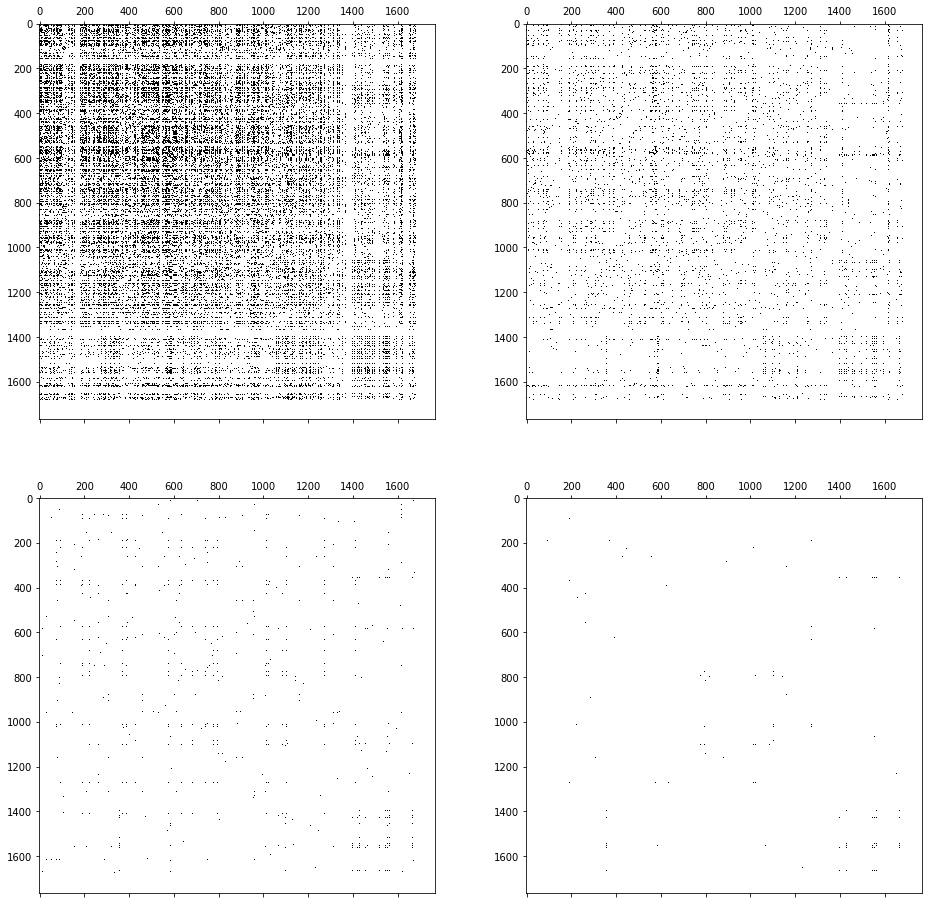

In [94]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].spy(keyword_graph1);
axes[0, 1].spy(keyword_graph2);
axes[1, 0].spy(keyword_graph3);
axes[1, 1].spy(keyword_graph4);

We will probably need to do additional transformations on the keyword data because i) the distance computations are expensive ii) not all keywords are equal. It might be benefitial to do a TF-IDF followed by a dimensionality reduction algorithm such as SVD, in order to compute distances and create a graph

### Create a cast vector

In [99]:
df_cast_ml = pd.merge(df, df_cast, on="movie_id")
df_cast_ml = pd.merge(df_cast_ml, df_roles, on="role_id")
df_cast_ml = df_cast_ml[["movie_id_ml","person_id","cast_role"]]
df_cast_ml.head()

,movie_id_ml,person_id,cast_role
0,1,30260,actor
1,1,46332,actor
2,1,46332,actor
3,1,66226,actor
4,1,128339,actor


In [100]:
np_cast = df_cast_ml.to_numpy()

In [101]:
cast_vector = np.zeros((df_ML_movies.shape[0], df_people.shape[0]))

for i in range(np_cast.shape[0]) :
    row = np_cast[i,0]-1
    column = np_cast[i,1]-1
    cast_vector[row, column] = 1
        

In [102]:
useful_cast = []

for i in range(cast_vector.shape[1]) :
    cnt = cast_vector[:,i].sum()
    if cnt > 1 :
        useful_cast += [i]
        
print(len(useful_cast))
cast_vector = cast_vector[:,useful_cast]
print(cast_vector.shape)
print(cast_vector.sum())

19932
(1767, 19932)
64946.0


In [103]:
cast_vector_sparse = sparse.csr_matrix(cast_vector)

In [104]:
cast_dist = np.zeros((df_ML_movies.shape[0], df_ML_movies.shape[0]))
for i in range(df_ML_movies.shape[0]) :
    for j in range(df_ML_movies.shape[0]) :
        if i != j :
            intersection = (cast_vector_sparse[i,:]*cast_vector_sparse[j,:].transpose())[0,0]
            if intersection != 0 :
                i_total = cast_vector_sparse[i,:].sum()
                j_total = cast_vector_sparse[j,:].sum()
                union = i_total + j_total - intersection
                jaccard = intersection / union
                cast_dist[i,j] = jaccard

In [105]:
np.save("cast.dat", cast_dist)

In [117]:
threshold1 = 0.001
threshold2 = 0.005
threshold3 = 0.01
threshold4 = 0.03

cast_graph1 = (cast_dist > threshold1).astype(int)
cast_graph2 = (cast_dist > threshold2).astype(int)
cast_graph3 = (cast_dist > threshold3).astype(int)
cast_graph4 = (cast_dist > threshold4).astype(int)

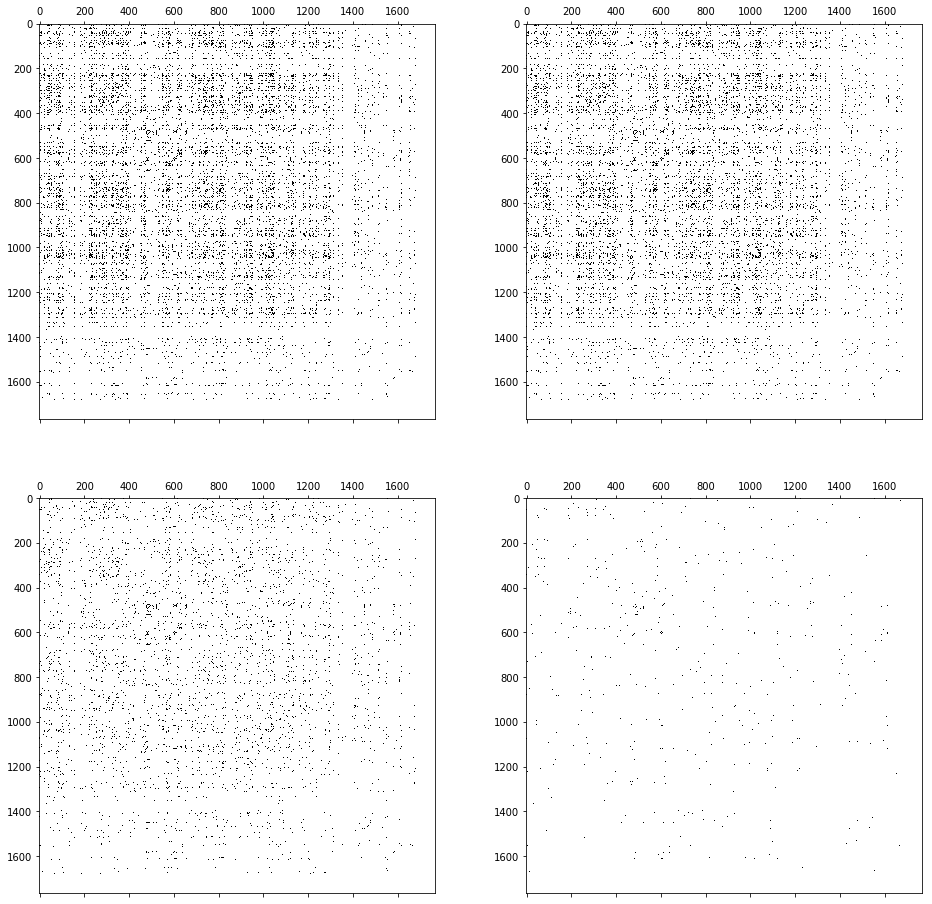

In [118]:
fig, axes = plt.subplots(2, 2, figsize=(16, 16))
axes[0, 0].spy(cast_graph1);
axes[0, 1].spy(cast_graph2);
axes[1, 0].spy(cast_graph3);
axes[1, 1].spy(cast_graph4);

### Create 3 dfs from IMDb

In [17]:
# df_movies, df_movie_keyword, df_keyword
df1 = pd.merge(df_IMDb_movies[df_IMDb_movies.movie_id.isin(movie_ids)], 
               df_movie_keyword[df_movie_keyword.movie_id.isin(movie_ids)], 
               on="movie_id")
df_movies_keywords = pd.merge(df1, df_keyword, on="keyword_id")
# merge with Movielens
df_movies_all = pd.merge(df_ML_movies, df_movies_keywords, on=["title", "release"])

# drop ids since already connected
df_movies_all = df_movies_all.drop(columns=["keyword_id", "movie_id_ml"])

print(df_movies_all.shape)
df_movies_all.head()

(102064, 24)


,title,release,url,unknown,action,adventure,animation,childrens,comedy,crime,documentary,drama,fantasy,noir,horror,musical,mystery,romance,scifi,thriller,war,western,movie_id,keyword
0,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2445635,walkie-talkie
1,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2445635,boy
2,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2445635,slow-motion
3,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2445635,villain-turns-good
4,toy story,1995,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,2445635,family-relationships


In [18]:
# df_cast, df_people, df_roles
df1 = pd.merge(df_cast[df_cast.movie_id.isin(movie_ids)], 
               df_people, 
               on="person_id")
df_cast_people = pd.merge(df1, df_roles, on="role_id")

# drop ids since already connected
df_cast_people = df_cast_people.drop(columns=["role_id", "cast_id", "person_id"])

print(df_cast_people.shape)
df_cast_people.head()

(123269, 4)


,movie_id,cast_name,cast_gender,cast_role
0,2113260,"$hort, Too",m,actor
1,2242727,"$hort, Too",m,actor
2,2430754,"'Dead End' Kids, The",m,actor
3,1910475,Aadil,m,actor
4,1949300,"Aaker, Lee",m,actor


In [19]:
# df_movie_companies, df_companies
df_movie_companies = pd.merge(df_movie_companies[df_cast.movie_id.isin(movie_ids)], 
                              df_companies, 
                              on="company_id")

# drop ids since already connected
df_movie_companies = df_movie_companies.drop(columns=["company_id"])

print(df_movie_companies.shape)
df_movie_companies.head()

(9060, 4)


/home/jelena/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:2: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  


,movie_id,note,name,country
0,51,(2010) (Canada) (TV),Canadian Television (CTV),[ca]
1,333123,(produced in association with) (as CTV),Canadian Television (CTV),[ca]
2,51,(2011) (Brazil) (TV),Warner Channel Latin America,[br]
3,68,(2011) (UK) (TV),5*,[gb]
4,6058,(1992) (USA) (TV),Columbia Broadcasting System (CBS),[us]


# Store new DFs

In [20]:
df_movies_all.to_csv("data/movies.csv", sep=',')
df_cast_people.to_csv("data/cast.csv", sep=',')
df_movie_companies.to_csv("data/companies.csv", sep=',')
df_ratings.to_csv("data/ratings.csv", sep=',')
df_users.to_csv("data/users.csv", sep=',')

---

# Read new DFs

In [1]:
import pandas as pd

In [2]:
df_movies_all = pd.read_csv("data/movies.csv", sep=',')
df_cast_people = pd.read_csv("data/cast.csv", sep=',')
df_movie_companies = pd.read_csv("data/companies.csv", sep=',')
df_ratings = pd.read_csv("data/ratings.csv", sep=',')
df_users = pd.read_csv("data/users.csv", sep=',')

In [3]:
import pandas_profiling

In [4]:
profile_movies = df_movies_all.profile_report(title='Movies Report')
profile_movies.to_file(output_file="data/movies_report.html")

In [5]:
profile_cast = df_cast_people.profile_report(title='Cast Report')
profile_cast.to_file(output_file="data/cast_report.html")

In [6]:
profile_companies = df_movie_companies.profile_report(title='Companies Report')
profile_companies.to_file(output_file="data/companies_report.html")

In [7]:
profile_ratings = df_ratings.profile_report(title='Ratings Report')
profile_ratings.to_file(output_file="data/ratings_report.html")

In [8]:
profile_users = df_users.profile_report(title='Users Report')
profile_users.to_file(output_file="data/users_report.html")